[View in Colaboratory](https://colab.research.google.com/github/meketag/AcousticSceneClassification/blob/master/ClassificationMel-SpectrogramResNet.ipynb)

In [0]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
%%bash
cd drive
cd Colab\ Notebooks
cd data
ls

melsp_test.npz
melsp_train_com.npz
melsp_train_raw.npz
melsp_train_ss.npz
melsp_train_st.npz
melsp_train_wn.npz


In [2]:
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.datasets import cifar10
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

Using TensorFlow backend.


In [0]:
data_dirname = 'drive/Colab Notebooks/data'

train_files = ['melsp_train_raw.npz',
               'melsp_train_wn.npz',
               'melsp_train_ss.npz',
               'melsp_train_st.npz',
               'melsp_train_com.npz']
test_file = 'melsp_test.npz'

In [4]:
def load_data(dirname, train_files, test_file):
  X_train = []
  y_train = []

  for file in train_files:
    data = np.load(dirname + '/' + file)
    X_train = data['x'] if len(X_train) == 0 else np.concatenate([X_train, data['x']], axis=0)
    y_train = data['y'] if len(y_train) == 0 else np.concatenate([y_train, data['y']], axis=0)

  data = np.load(dirname + '/' + test_file)
  X_test = data['x']
  y_test = data['y']

  return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data(data_dirname, train_files, test_file)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5850, 128, 128, 3) (5850,)
(390, 128, 128, 3) (390,)


In [0]:
scene_labels = np.array([
    'beach',
    'bus',
    'cafe/restaurant',
    'car',
    'city_center',
    'forest_path',
    'grocery_store',
    'home',
    'library',
    'metro_station',
    'office',
    'park',
    'residential_area',
    'train',
    'tram'])

(5850, 128, 128, 3) (5850,)
(390, 128, 128, 3) (390,)


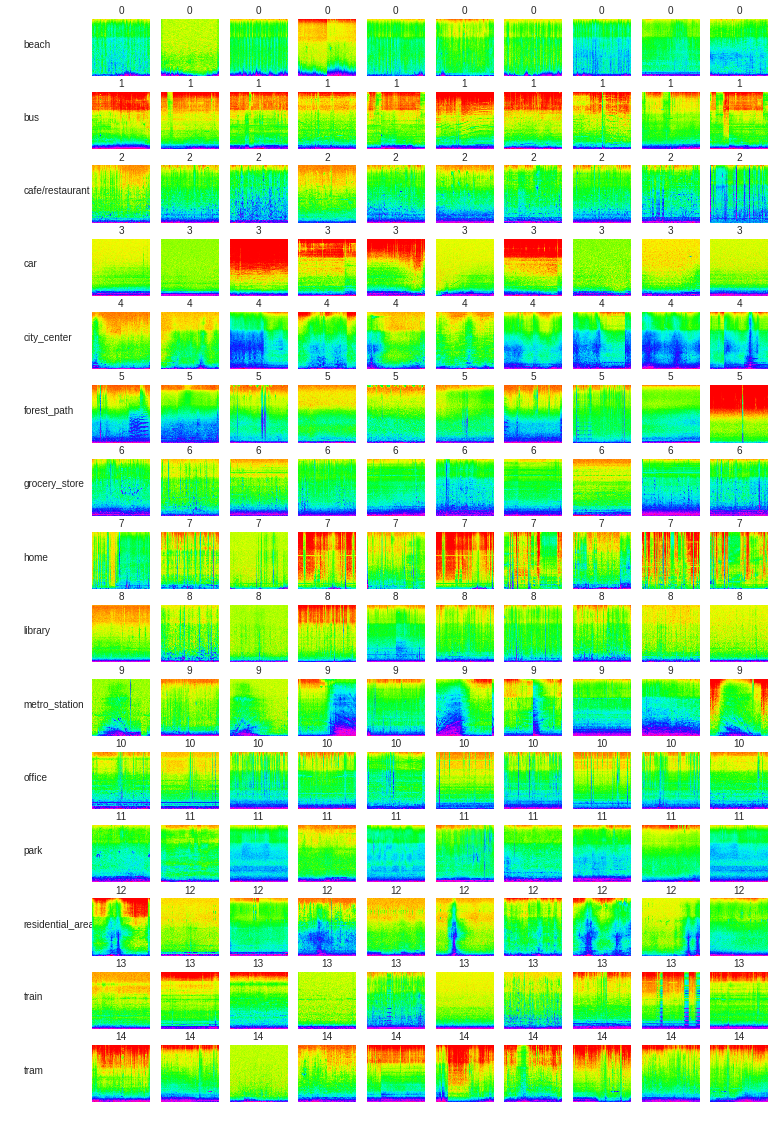

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

nclasses = 15
pos = 1
plt.figure(figsize=(16, 24), dpi=60)

for targetClass in range(nclasses):
    targetIdx = []
    for i in range(len(y_train)):
        if y_train[i] == targetClass:
            targetIdx.append(i)

    plt.subplot(15, 10+1, pos)
    plt.text(0, 0.5, scene_labels[targetClass])
    plt.axis('off')
    pos += 1

    np.random.shuffle(targetIdx)
    for idx in targetIdx[:10]:
        img = toimage(X_train[idx])
        plt.subplot(15, 10+1, pos)
        plt.imshow(img)
        plt.axis('off')
        plt.title(y_train[idx])
        pos += 1

plt.show()

In [0]:
# floatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0

# one-hot vector に変換したほうが都合が良い
n_classes = 15
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

In [10]:
#
# ResNet のモデルを定義するセル
#

# inputs と residual 2つの処理結果を受け取って、両者を足す
def _shortcut(inputs, residual):
  
  # residual のほうのフィルタ数を取得する
  # ちなみに
  # _keras_shape[1] 画像の幅
  # _keras_shape[2] 画像の高さ
  # _keras_shape[3] チャンネル数
  # になっている(デフォルトでは)。
  # 本当はチャンネル数、幅、高さの順番のこともあるので
  # それを考慮したコードにしなければならないのだが、今回はこれで問題ない
  n_filters = residual._keras_shape[3]
  
  # inputs と residual とでチャネル数が違うかもしれない。
  # そのままだと足せないので、1x1 conv を使って residual 側のフィルタ数に合わせている
  shortcut = Convolution2D(n_filters, (1,1), strides=(1,1), padding='valid')(inputs)
  
  # 2つを足す
  return add([shortcut, residual])


# ResBlock を定義
# ここでの処理は BatchNorm → ReLU → Conv とシンプルなものにしてあるが、
# ここを色々変更する改良案が無数にある
def _resblock(n_filters, strides=(1,1)):
  def f(input):
    bn = BatchNormalization()(input)
    act = Activation('relu')(bn)
    conv = Convolution2D(n_filters, (3,3), strides=strides,
                         kernel_initializer='he_normal', padding='same')(act)
    
    x = Convolution2D(n_filters, (3,3), strides=strides,
                                      kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(n_filters, (3,3), strides=strides,
                                      kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)
    
    # 入力そのものと、BN→ReLU→Conv したものとを足す
    # この部分がResNetのもっとも重要な点
    #return _shortcut(input, x)
    return Activation('relu')(_shortcut(input, x))
    
  return f


def resnet():
  # 入力テンソルを定義しておく
  inputs = Input(shape=(128, 128, 3))
  
  # ResBlock で処理をする前に、いったん
  # 7x7で畳み込み→BN→ReLU　をし、さらに MaxPooling している
  # これは無くても動くが、早い段階でとりあえずMaxPoolingすることで画像サイズが1/2になるので
  # パラメータ数の増加を抑える(高速に学習できる)効果がある
  
  # 7x7conv→BN→ReLU
  x = Convolution2D(32, (7,7), strides=(1,1), padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  # MaxPoolingで縮小
  x = MaxPooling2D((3, 3), strides=(2,2), padding='same')(x)
  
  #ここからは ResBlock を積み重ねていく
  # 下では ResBlock x3 → MaxPooling → ResBlock x3 という非常に小さいネットワーク
  
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = MaxPooling2D(strides=(2,2))(x)  
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = MaxPooling2D(strides=(2,2))(x)  
  x = _resblock(n_filters=256)(x)
  x = _resblock(n_filters=256)(x)
  x = _resblock(n_filters=256)(x)
  x = _resblock(n_filters=256)(x)
  x = _resblock(n_filters=256)(x)
  x = _resblock(n_filters=256)(x)

  # Global Average Pooling したあとに Fully Connection Network ( = Dense) する
  x = GlobalAveragePooling2D()(x)
  x = Dense(15, kernel_initializer='he_normal', activation='softmax')(x)
  
  # Keras では、入力と出力の2個だけを指定すると、計算に必要なネットワークを勝手に構築してくれる機能がある
  # inputs は初めに定義しておいた  Input(shape=(32, 32, 3)) で、
  # outputs は softmax で10個の出力を行う Dense のネットワークなので、その2つを指定する
  model = Model(inputs=inputs, outputs=x)
  return model

model = resnet()

# optimizer として Adam を指定する。SGDでも良いがAdamのほうが収束が早い
adam = Adam()

# inputs から outputs を求める計算をするようにコンパイルする
# ここでネットワークでどのような処理を行うかが全て決定される
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 今作ったネットワークがどんなネットワークなのか概要を表示する機能(見られるだけなので無くても良い)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 128, 128, 32) 4736        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 128, 128, 32) 128         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 128, 128, 32) 0           batch_normalization_56[0][0]     
__________________________________________________________________________________________________
max_poolin

In [11]:
# 1 epoch ごとに　weights.01.hdf5, weights.02.hdf5 … のようにモデルを保存してくれる
callback_cp = ModelCheckpoint(filepath='drive/Colab Notebooks/weights.{epoch:02d}.hdf5')

# 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
callback_es = EarlyStopping(monitor='val_acc', patience=2, mode='auto', verbose=1)

batch_size = 50
epochs = 10 * 3

# 学習する
h = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2)
              #callbacks=[callback_cp, callback_es])

# 学習が終わった最終状態を保存する
model.save('drive/Colab Notebooks/model.hdf5')

Train on 4680 samples, validate on 1170 samples
Epoch 1/30
4680/4680 [==============================] - 73s 16ms/step - loss: 1.7307 - acc: 0.4051 - val_loss: 8.3560 - val_acc: 0.1650
Epoch 2/30
4680/4680 [==============================] - 65s 14ms/step - loss: 1.1202 - acc: 0.6194 - val_loss: 6.8402 - val_acc: 0.1547
Epoch 3/30
4680/4680 [==============================] - 65s 14ms/step - loss: 0.7762 - acc: 0.7382 - val_loss: 6.9994 - val_acc: 0.1983
Epoch 4/30
4680/4680 [==============================] - 65s 14ms/step - loss: 0.5792 - acc: 0.8081 - val_loss: 2.4225 - val_acc: 0.4615
Epoch 5/30
4680/4680 [==============================] - 65s 14ms/step - loss: 0.3380 - acc: 0.8893 - val_loss: 7.5805 - val_acc: 0.2274
Epoch 6/30
4680/4680 [==============================] - 65s 14ms/step - loss: 0.2470 - acc: 0.9190 - val_loss: 1.5427 - val_acc: 0.6060
Epoch 7/30
4680/4680 [==============================] - 65s 14ms/step - loss: 0.1867 - acc: 0.9365 - val_loss: 1.2704 - val_acc: 0.6803


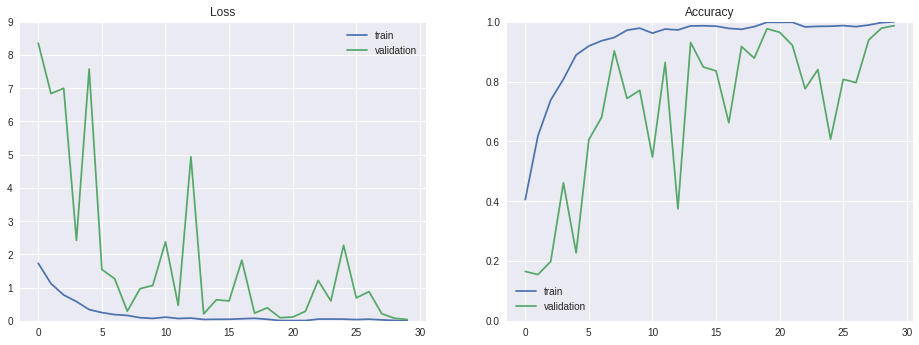

In [12]:
import numpy as np
import matplotlib.pyplot as plt

epoch = np.arange(len(h.history['acc']))

fig = plt.gcf()
size = fig.get_size_inches()
size[0] *= 2.0

plt.figure(figsize=size)

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.ylim(0.0, np.ceil(np.max(h.history['val_loss'])))
plt.plot(epoch, h.history['loss'], label='train')
plt.plot(epoch, h.history['val_loss'], label='validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.ylim(0.0, 1.0)
plt.plot(epoch, h.history['acc'], label='train')
plt.plot(epoch, h.history['val_acc'], label='validation')
plt.legend()

plt.show()

In [13]:
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

390/390 [==============================] - 2s 6ms/step
Test loss: 1.8312067129673102
Test accuracy: 0.6717948717948717


0.6717948717948717
                  be  bu  ca  ca  ci  fo  gr  ho  li  me  of  pa  re  tr  tr
beach             24   0   0   0   0   2   0   0   0   0   0   0   0   0   0
bus                0  17   0   0   0   0   0   0   1   0   0   0   1   6   1
cafe/restaurant    0   0   8   0   0   0   5   1   0   8   0   0   0   4   0
car                0   0   0  15   0   0   0   0   0   0   0   2   0   8   1
city_center        0   0   0   0  18   0   0   0   0   1   0   3   4   0   0
forest_path        0   0   0   0   0  26   0   0   0   0   0   0   0   0   0
grocery_store      0   0   0   0   0   1  24   0   1   0   0   0   0   0   0
home               0   0   0   0   0   2   3  18   3   0   0   0   0   0   0
library            0   1   0   0   0   1   2   1  19   1   0   0   0   1   0
metro_station      0   0   1   0   1   0   1   0   1  16   0   0   2   3   1
office             0   0   1   0   0   0   2   1   3   0  12   0   0   0   7
park               9   0   0   1   0   0   0   0   0   0 

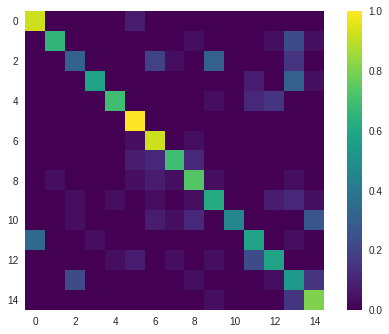

In [14]:
import pandas as pd

results_proba = model.predict(X_test)
results_classes = np.argmax(results_proba, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

print(np.sum(results_classes == y_test_classes) / len(y_test_classes))

cross = pd.crosstab(y_test_classes, results_classes)
cross.index = scene_labels
cross.columns = [str[:2] for str in scene_labels]
print(cross)

plt.imshow(cross / 26, vmax=1.0, cmap='viridis')
plt.colorbar()
plt.grid('off')